用于详细观察连接权重生成函数的影响的笔记本

In [7]:
import torch
import matplotlib.pyplot as plt
from functions import load_config_yaml
import torch.distributions as dist

def ab_gamma(mu, sigma):
    # mu: mean of gamma distribution
    # sigma: standard deviation of gamma distribution
    # return a, b parameters of gamma distribution
    # a = mu^2/sigma^2, b = mu/sigma^2
    a = mu ** 2 / sigma ** 2
    b = mu / sigma ** 2
    return a, b

def Generate_Vectors(N, mu=1, sigma=0.1,seed=None):

    # seed: random seed
    # 让m,n,sti_nogo只在0:N_E之间有值
    # Construct non-negative, orthogonal vectors m, n, Sti_nogo (sampled from gamma distribution)
    # make sure the vectors have the same norm (beta分布取从0到1的均匀分布)
    # vectors m, n, Sti_nogo are all in the length of N (size: N,1), while occupy different dimensions
    m = torch.zeros(N, 1)
    n = torch.zeros(N, 1)
    Sti_nogo = torch.zeros(N, 1)
    temp = torch.rand(N, 1)
    mask_m = temp < 0.33
    mask_n = (temp >= 0.33) & (temp < 0.66)
    mask_Sti_nogo = temp >= 0.66
    # generate a, b parameters
    alpha, beta = ab_gamma(mu, sigma)
    # generate vectors m, n, Sti_nogo
    m[mask_m] = dist.Gamma(alpha, beta).sample((sum(mask_m), 1)).squeeze()
    n[mask_n] = dist.Gamma(alpha, beta).sample((sum(mask_n), 1)).squeeze()
    Sti_nogo[mask_Sti_nogo] = dist.Gamma(alpha, beta).sample((sum(mask_Sti_nogo), 1)).squeeze()
    # normalize the vectors
    print("m norm:", torch.norm(m))
    print("n norm:", torch.norm(n))
    print("Sti_nogo norm:", torch.norm(Sti_nogo))

    m[N_E:] = 0
    n[N_E:] = 0
    Sti_nogo[N_E:] = 0

    # m = m / torch.norm(m)
    # n = n / torch.norm(n)
    # Sti_nogo = Sti_nogo / torch.norm(Sti_nogo)
    return m, n, Sti_nogo

def Generate_RandomMatrix(N_E, N_I, P_EE, P_EI, P_IE, P_II, W_rank1, sigma=0.1):
    # Construct random weight matrix
    # use beta distribution to generate random matrix
    # W_rank1: low rank matrix
    # deside the average value of the beta distribution according to the rank-1 matrix to make sure
    # the average value of the sum of the rank-1 matrix and the random matrix is according to the P_EE, P_EI, P_IE, P_II
    N = N_E + N_I
    W = torch.zeros(N, N)

    mu_EE = P_EE - torch.sum(W_rank1[:N_E, :N_E]) / (N_E * N_E)
    mu_EI = P_EI - torch.sum(W_rank1[:N_E, N_E:]) / (N_E * N_I)
    mu_IE = P_IE - torch.sum(W_rank1[N_E:, :N_E]) / (N_I * N_E)
    mu_II = P_II - torch.sum(W_rank1[N_E:, N_E:]) / (N_I * N_I)

    # 生成a,b参数
    # 打印出来看看
    a_EE, b_EE = ab_gamma(mu_EE, sigma)
    a_EI, b_EI = ab_gamma(mu_EI, sigma)
    a_IE, b_IE = ab_gamma(mu_IE, sigma)
    a_II, b_II = ab_gamma(mu_II, sigma)

    # print("a_EE, b_EE, average value:", a_EE, b_EE, mu_EE)
    # print("a_EI, b_EI, average value:", a_EI, b_EI, mu_EI)
    # print("a_IE, b_IE, average value:", a_IE, b_IE, mu_IE)
    # print("a_II, b_II, average value:", a_II, b_II, mu_II)

    # 生成连接矩阵
    W[:N_E, :N_E] = dist.Gamma(a_EE,b_EE).sample((N_E,N_E))
    W[:N_E, N_E:] = dist.Gamma(a_EI, b_EI).sample((N_E, N_I))
    W[N_E:, :N_E] = dist.Gamma(a_IE, b_IE).sample((N_I, N_E))
    W[N_E:, N_E:] = dist.Gamma(a_II, b_II).sample((N_I, N_I))
    return W

config = load_config_yaml('config_test.yaml')
N_E = config['N_E']
N_I = config['N_I']
N = N_E + N_I
P_EE = config['P_EE']
P_EI = config['P_EI']
P_IE = config['P_IE']
P_II = config['P_II']
factor_mn = config['factor_mn'] # 组合成conn时乘在lowrank matrix上的常數
RS = config['RandomStrength'] # 组合成conn时乘在random matrix上的常數
taud_E = config['taud_E']
taud_I = config['taud_I']
ratio_fast = config['ratio_fast']
if type(taud_E) == list: # introduce fast and slow time constants
    mask_tauE = torch.rand(1, N_E) < ratio_fast
    mask_tauI = torch.rand(1, N_I) < ratio_fast
    tau_E = torch.ones(1, N_E) * taud_E[1]
    tau_E[mask_tauE] = taud_E[0]
    tau_I = torch.ones(1, N_I) * taud_I[1]
    tau_I[mask_tauI] = taud_I[0]
    taud_E = tau_E.tolist()
    taud_I = tau_I.tolist()
mu = config['mu']
si = config['sigma']
mu_rand = config['mu_rand']
si_rand = config['sigma_rand']
dt = config['dt'] #(ms/step)
T_pre = config['T_pre'] # length of time before sti (ms)
T_sti = config['T_sti'] # length of time for sti (ms)
T_after = config['T_after'] # length of time after sti (ms)
T = T_pre+T_sti+T_after # length of Period time (ms): 30ms
IS = config['InputStrength'] #Input Strength (maybe chage to norm in the future)
color_Go = config['color_Go']
color_Nogo = config['color_Nogo']





m norm: tensor(1.0685)
n norm: tensor(1.1135)
Sti_nogo norm: tensor(1.1158)


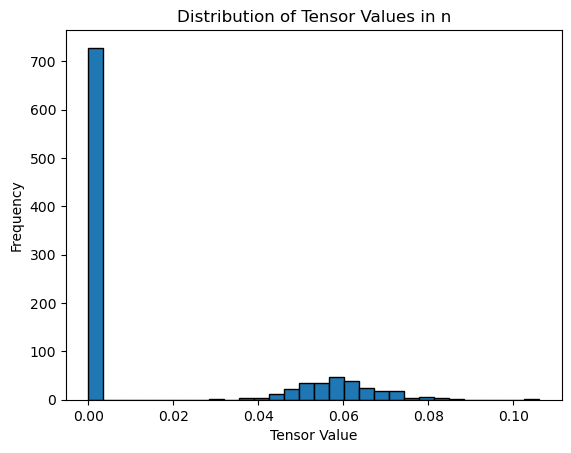

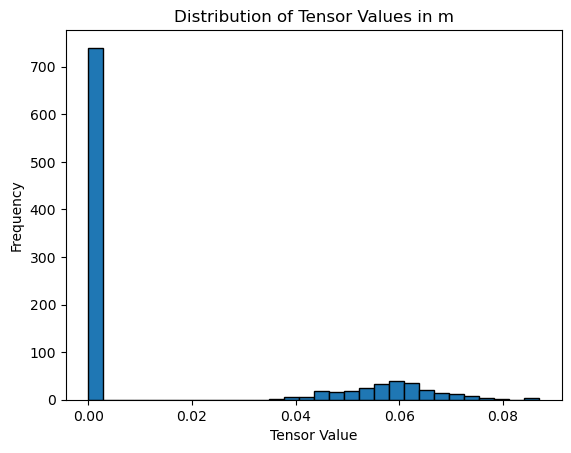

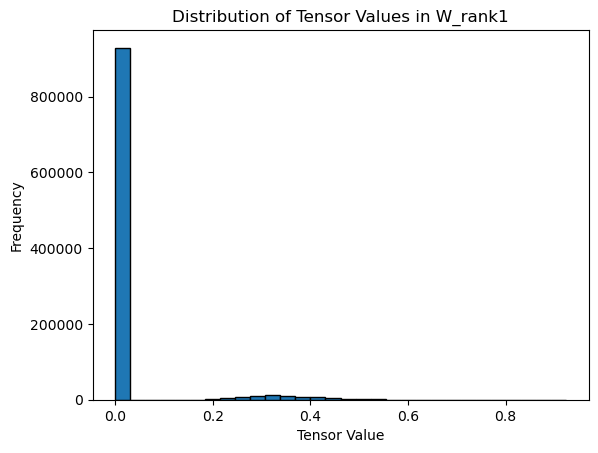

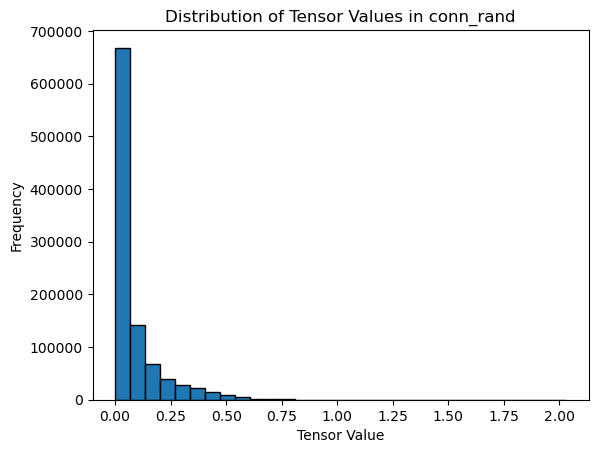

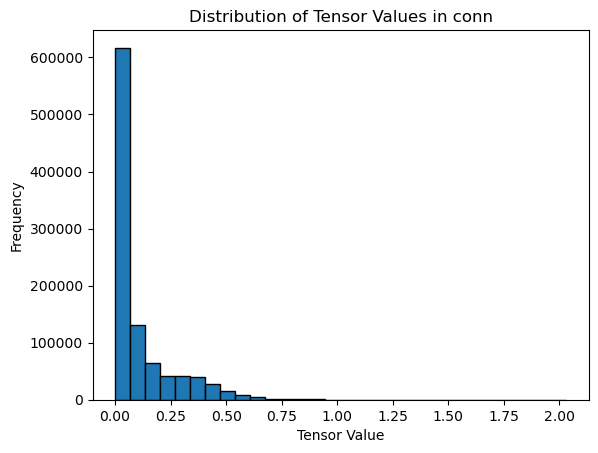

In [14]:
def plot_hist(n,name):
    # 将Tensor转换为numpy数组以用于matplotlib
    tensor_numpy = n.flatten().numpy()

    # 绘制直方图
    plt.hist(tensor_numpy, bins=30, edgecolor='black')
    plt.xlabel('Tensor Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Tensor Values in '+ name)
    plt.show()
# 创建m,n,sti_nogo
# tensor = torch.randn(1000)
m, n, Sti_nogo = Generate_Vectors(N, mu, si)
Sti_go = n.clone()
W_out = m.clone()
W_rank1 = factor_mn*(torch.ger(m.squeeze(), n.squeeze()))
conn_rand = Generate_RandomMatrix(N_E, N_I, P_EE, P_EI, P_IE, P_II, W_rank1, sigma = si_rand)
conn = W_rank1 + RS*conn_rand

plot_hist(n,'n')
plot_hist(m,'m')
# plot_hist(Sti_nogo,'Sti_nogo')
# plot_hist(Sti_go,'Sti_go')
# plot_hist(W_out,'W_out')
plot_hist(W_rank1,'W_rank1')
plot_hist(conn_rand,'conn_rand')
plot_hist(conn,'conn')